In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import sys

from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import pos_tag, wordnet
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from wordcloud import WordCloud

nltk.download('vader_lexicon')

#Settings
pd.options.display.float_format = '{:.2f}'.format
np.set_printoptions(threshold=sys.maxsize)
sns.set()
DIMS=(10, 10)


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
print("Downloading corpora...")    
nltk.download('punkt')                        # Sentence Tokenizer
nltk.download('stopwords')                    # For stopwords in all languages
nltk.download('averaged_perceptron_tagger')   # For Sentiment analysis
nltk.download('wordnet')                      # For Lemmas
print("Downloads complete.")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
Downloads complete.


In [3]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/")

reviews_df = pd.read_csv('Womens-Clothing-E-Commerce-Reviews.csv',index_col=0)
reviews_df.head()

Mounted at /content/drive


,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


Pre-processing

In [4]:
reviews_df.isnull().sum()                # Check for null values 

Clothing ID                   0
Age                           0
Title                      3810
Review Text                 845
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                14
Department Name              14
Class Name                   14
dtype: int64

In [5]:
reviews_df_drop = reviews_df.copy()
reviews_df_drop.dropna(axis=0, inplace=True)     # droping Null Values
reviews_df_drop.isnull().sum()   

Clothing ID                0
Age                        0
Title                      0
Review Text                0
Rating                     0
Recommended IND            0
Positive Feedback Count    0
Division Name              0
Department Name            0
Class Name                 0
dtype: int64

In [6]:
reviews_df_drop['Clothing ID'].nunique()

1095

In [7]:
reviews_df.shape

(23486, 10)

In [8]:
reviews_df_drop.shape

(19662, 10)

Text Normalization

In [9]:
def clean_string(r):
    #remove regular expression and change to lowercase
    r1 = re.sub('[^A-Za-z]+', ' ', str(r))
    r1 = r1.strip().lower()
   
    #remove stopwords
    no_sw = []
    if r1 not in stopwords.words():
        no_sw.append(r1)
        
    #perform stemming
    stemmer = PorterStemmer() 
    final_list = []

    for i in no_sw:
        final_list.append(stemmer.stem(str(i)))
        
    #Lemmatization
    lema = WordNetLemmatizer() 
    final_list = []

    for i in no_sw:
        final_list.append(lema.lemmatize(str(i)))
                
    return final_list

In [10]:
only_reviews_df = reviews_df_drop.copy()
only_reviews_df= only_reviews_df[['Clothing ID','Review Text', 'Age', 'Recommended IND']]
only_reviews_df['Filtered Reviews'] = only_reviews_df['Review Text'].apply(clean_string)
only_reviews_df.head()

,Clothing ID,Review Text,Age,Recommended IND,Filtered Reviews
2,1077,I had such high hopes for this dress and reall...,60,0,[i had such high hopes for this dress and real...
3,1049,"I love, love, love this jumpsuit. it's fun, fl...",50,1,[i love love love this jumpsuit it s fun flirt...
4,847,This shirt is very flattering to all due to th...,47,1,[this shirt is very flattering to all due to t...
5,1080,"I love tracy reese dresses, but this one is no...",49,0,[i love tracy reese dresses but this one is no...
6,858,I aded this in my basket at hte last mintue to...,39,1,[i aded this in my basket at hte last mintue t...


In [11]:
sid = SentimentIntensityAnalyzer()

num_records = only_reviews_df.shape[0]
ones_array = np.ones(num_records)
    
only_reviews_df['Compound score'] = ones_array

for i in range(len(only_reviews_df['Filtered Reviews'])):

    element = only_reviews_df['Filtered Reviews'].iloc[i][0]
#    print(element)
    score = sid.polarity_scores(element)
#    print(score)
    compound = score['compound']
#    print(compound)
    only_reviews_df['Compound score'].iloc[i] = compound
only_reviews_df.head(n=10)
#    pd.set_option('display.max_rows', only_reviews_df.shape[0]+1)
#    print(only_reviews_df)


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Clothing ID,Review Text,Age,Recommended IND,Filtered Reviews,Compound score
2,1077,I had such high hopes for this dress and reall...,60,0,[i had such high hopes for this dress and real...,0.94
3,1049,"I love, love, love this jumpsuit. it's fun, fl...",50,1,[i love love love this jumpsuit it s fun flirt...,0.48
4,847,This shirt is very flattering to all due to th...,47,1,[this shirt is very flattering to all due to t...,0.92
5,1080,"I love tracy reese dresses, but this one is no...",49,0,[i love tracy reese dresses but this one is no...,0.94
6,858,I aded this in my basket at hte last mintue to...,39,1,[i aded this in my basket at hte last mintue t...,0.46
7,858,"I ordered this in carbon for store pick up, an...",39,1,[i ordered this in carbon for store pick up an...,-0.09
8,1077,I love this dress. i usually get an xs but it ...,24,1,[i love this dress i usually get an xs but it ...,0.72
9,1077,"I'm 5""5' and 125 lbs. i ordered the s petite t...",34,1,[i m and lbs i ordered the s petite to make su...,-0.37
10,1077,Dress runs small esp where the zipper area run...,53,0,[dress runs small esp where the zipper area ru...,0.23
12,1095,More and more i find myself reliant on the rev...,53,1,[more and more i find myself reliant on the re...,0.55


Classify sentiments into positive, negative, neutral

In [12]:
category = []

for i in only_reviews_df['Compound score']: 
    
    if i > 0:
        category.append('Positive')

    elif i < 0:
        category.append('Negative')

    else:
        category.append('Neutral')

only_reviews_df['Sentiment category'] = category
only_reviews_df.tail(n=10)

,Clothing ID,Review Text,Age,Recommended IND,Filtered Reviews,Compound score,Sentiment category
23475,1104,Cute dress but not for me. the waist is too h...,41,1,[cute dress but not for me the waist is too hi...,0.79,Positive
23476,522,These bottoms are very cute but defiantly chee...,27,1,[these bottoms are very cute but defiantly che...,0.70,Positive
23477,1094,I'm so impressed with the beautiful color comb...,39,1,[i m so impressed with the beautiful color com...,-0.75,Negative
23478,1104,I was surprised at the positive reviews for th...,32,0,[i was surprised at the positive reviews for t...,-0.71,Negative
23479,1005,So i wasn't sure about ordering this skirt bec...,42,1,[so i wasn t sure about ordering this skirt be...,0.97,Positive
23481,1104,I was very happy to snag this dress at such a ...,34,1,[i was very happy to snag this dress at such a...,0.91,Positive
23482,862,"It reminds me of maternity clothes. soft, stre...",48,1,[it reminds me of maternity clothes soft stret...,0.67,Positive
23483,1104,"This fit well, but the top was very see throug...",31,0,[this fit well but the top was very see throug...,0.93,Positive
23484,1084,I bought this dress for a wedding i have this ...,28,1,[i bought this dress for a wedding i have this...,0.82,Positive
23485,1104,This dress in a lovely platinum is feminine an...,52,1,[this dress in a lovely platinum is feminine a...,0.93,Positive


In [13]:
sentiment_catagory_df = only_reviews_df.copy()
sentiment_catagory_df = sentiment_catagory_df[['Filtered Reviews', 'Sentiment category']]
sentiment_catagory_df

,Filtered Reviews,Sentiment category
2,[i had such high hopes for this dress and real...,Positive
3,[i love love love this jumpsuit it s fun flirt...,Positive
4,[this shirt is very flattering to all due to t...,Positive
5,[i love tracy reese dresses but this one is no...,Positive
6,[i aded this in my basket at hte last mintue t...,Positive
...,...,...
23481,[i was very happy to snag this dress at such a...,Positive
23482,[it reminds me of maternity clothes soft stret...,Positive
23483,[this fit well but the top was very see throug...,Positive
23484,[i bought this dress for a wedding i have this...,Positive


No. of Positive, Negaive and Neutral 

In [14]:
num_sentiment_df = only_reviews_df.copy()
num_sentiment_df = num_sentiment_df[['Clothing ID', 'Sentiment category']]
num_sentiment_agg = num_sentiment_df.groupby('Sentiment category').size().reset_index(name='No. of sentiments')
num_sentiment_agg

,Sentiment category,No. of sentiments
0,Negative,1080
1,Neutral,96
2,Positive,18486


In [15]:
num_sentiment_agg.columns

Index(['Sentiment category', 'No. of sentiments'], dtype='object')

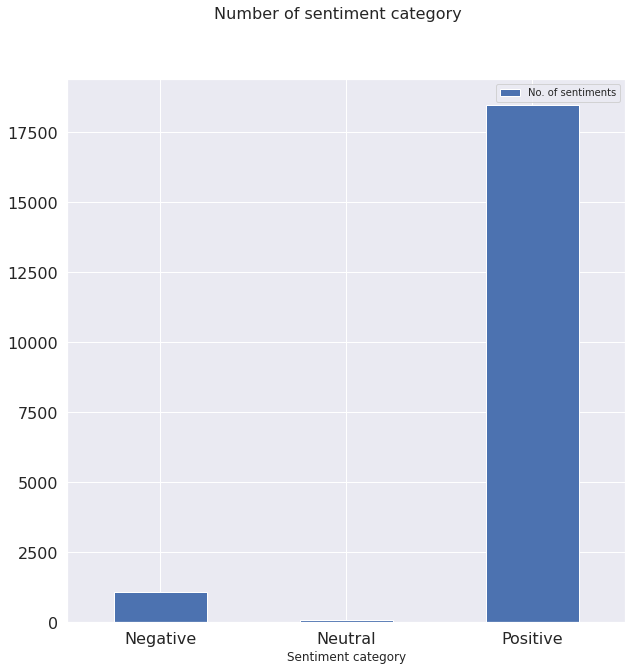

In [16]:
fig, ax = plt.subplots()
num_sentiment_agg.plot(kind='bar', x='Sentiment category', y='No. of sentiments', figsize = DIMS, ax=ax, rot=0, fontsize = 16)
fig.suptitle('Number of sentiment category', fontsize=16)
ax.legend(['No. of sentiments'], fontsize='10')
DIMS=(10, 10)

In [17]:
X = only_reviews_df['Sentiment category']
y = only_reviews_df['Recommended IND']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25)

In [18]:
count_vect = CountVectorizer()      #Apply CountVectorizer and TdidfTransformer transformations
tfidf_tfm = TfidfTransformer()
train_df_counts = count_vect.fit_transform(X_train)
train_df_tfidf = tfidf_tfm.fit_transform(train_df_counts)

In [19]:
clf = MultinomialNB().fit(train_df_tfidf, y_train)

In [20]:
count_test_vect = count_vect.transform(X_test)
y_predict = clf.predict(count_test_vect)

In [21]:
y_confusion_df = pd.DataFrame({"y_test": y_test, "y_predict" : y_predict} )
y_confusion_df.head()

,y_test,y_predict
4809,1,1
11855,1,1
8348,1,1
21174,1,1
10103,0,1


In [22]:
cm = confusion_matrix(y_test, y_predict)
cm

array([[ 183,  756],
       [  93, 3884]])

In [23]:
print("True negatives:", (cm[0][0]))
print("True positives:", (cm[1][1]))
print("False negatives:", (cm[0][1]))
print("Total:", (sum(sum(cm))))
print("Accuracy:", ((cm[0][0] + cm[1][1])/sum(sum(cm))))
print("Proportion of False negatives:", (cm[0][1] /sum(sum(cm))))

True negatives: 183
True positives: 3884
False negatives: 756
Total: 4916
Accuracy: 0.8272986167615948
Proportion of False negatives: 0.15378356387306755


In [24]:
only_reviews_df['id'] = only_reviews_df.index
y_confusion_df['id'] = y_confusion_df.index

wrong_indices = y_confusion_df[
    y_confusion_df['y_test'] == y_confusion_df['y_predict']].index

mismatch_df = only_reviews_df.merge(y_confusion_df, on='id')
mismatch_df = mismatch_df[mismatch_df['id'].isin(wrong_indices)]
mismatch_df.head()

,Clothing ID,Review Text,Age,Recommended IND,Filtered Reviews,Compound score,Sentiment category,id,y_test,y_predict
0,1049,"I love, love, love this jumpsuit. it's fun, fl...",50,1,[i love love love this jumpsuit it s fun flirt...,0.48,Positive,3,1,1
1,767,Bought the black xs to go under the larkspur m...,44,1,[bought the black xs to go under the larkspur ...,0.58,Positive,13,1,1
2,1065,I took these out of the package and wanted the...,47,1,[i took these out of the package and wanted th...,0.98,Positive,15,1,1
3,89,"First, this is thermal ,so naturally i didn't ...",67,1,[first this is thermal so naturally i didn t e...,0.96,Positive,43,1,1
4,862,Really cute top! the embroidery on the collar ...,33,1,[really cute top the embroidery on the collar ...,0.97,Positive,49,1,1


In [25]:
spl = mismatch_df.sample(3)
print(spl[['Clothing ID', 'id','y_test','y_predict']])
print()
print(spl.iloc[0]['Filtered Reviews'])

      Clothing ID     id  y_test  y_predict
2376         1096  11270       1          1
3354         1035  15943       1          1
4139          862  19673       1          1

['this dress could have been great but for me there was too much design on the top part front i wish the neckline was different or just less beadwork design near my face all in all its a maxi dress and was returned because approx was too much to spend on this']
